In [63]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

In [64]:
# import the data and  drop no longer needed columns 
video_df = pd.read_csv("data/videos_prepared.csv")

remove_columns = ["video_id", "title", "channel_title"]
video_df.drop(columns=remove_columns, inplace=True)
video_df.head()

,caption,hour_published,weekday_published,month_published,hd,cat_Comedy,cat_Education,cat_Entertainment,cat_Film & Animation,cat_Gaming,...,term_year,term_years,term_youtu,term_youtube,log_view_count,log_channel_view_count,log_channel_sub_count,log_channel_video_count,log_duration_seconds,cbrt_description_length
0,0,0,6,11,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.242716,7.828038,11.927885,7.384610,5.752573,3.555348,9.976612
1,0,20,4,4,1,0,0,0,0,0,...,0.0,0.237702,0.0,0.063177,7.350516,12.850665,8.366603,5.389072,8.147288,11.965177
2,0,18,3,10,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,7.446001,14.875077,8.767329,6.741701,3.951244,13.871269
3,0,19,0,11,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,5.937536,10.890628,6.786717,4.867534,4.955827,5.325074
4,1,20,2,10,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,12.229037,17.917472,13.030250,5.940171,6.678342,6.431228


In [65]:
# import the data and  drop no longer needed columns 
video_df = pd.read_csv("data/videos_prepared.csv")

remove_columns = ["video_id", "title", "channel_title"]
video_df.drop(columns=remove_columns, inplace=True)
video_df.head()

,caption,hour_published,weekday_published,month_published,hd,cat_Comedy,cat_Education,cat_Entertainment,cat_Film & Animation,cat_Gaming,...,term_year,term_years,term_youtu,term_youtube,log_view_count,log_channel_view_count,log_channel_sub_count,log_channel_video_count,log_duration_seconds,cbrt_description_length
0,0,0,6,11,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.242716,7.828038,11.927885,7.384610,5.752573,3.555348,9.976612
1,0,20,4,4,1,0,0,0,0,0,...,0.0,0.237702,0.0,0.063177,7.350516,12.850665,8.366603,5.389072,8.147288,11.965177
2,0,18,3,10,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,7.446001,14.875077,8.767329,6.741701,3.951244,13.871269
3,0,19,0,11,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,5.937536,10.890628,6.786717,4.867534,4.955827,5.325074
4,1,20,2,10,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,12.229037,17.917472,13.030250,5.940171,6.678342,6.431228


In [66]:
# split into features and target variable

X = video_df.drop(columns="log_view_count")
y = video_df["log_view_count"]

# split into training and test data
SEED = 666
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train.head()

,caption,hour_published,weekday_published,month_published,hd,cat_Comedy,cat_Education,cat_Entertainment,cat_Film & Animation,cat_Gaming,...,term_www,term_year,term_years,term_youtu,term_youtube,log_channel_view_count,log_channel_sub_count,log_channel_video_count,log_duration_seconds,cbrt_description_length
33,0,13,1,3,1,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,13.930310,5.613128,3.951244,5.926926,5.167649
242,1,12,4,10,1,0,0,0,0,0,...,0.110052,0.0,0.0,0.0,0.000000,18.659140,14.159101,5.370638,6.115892,11.477587
455,0,19,0,1,1,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.059560,15.796762,11.455307,6.287859,8.357259,11.990734
342,0,12,0,9,1,0,0,1,0,0,...,0.379471,0.0,0.0,0.0,0.364798,14.976286,10.645449,5.762051,6.719013,9.480106
67,0,23,6,3,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,9.933871,4.007333,2.995732,6.361302,5.718479


In [ ]:
# instantiate the scaler, fit it to training data and transform training and test features
# scaler = StandardScaler()

# X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
# X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
# X_train_scaled

,caption,hour_published,weekday_published,month_published,hd,cat_Comedy,cat_Education,cat_Entertainment,cat_Film & Animation,cat_Gaming,...,term_www,term_year,term_years,term_youtu,term_youtube,log_channel_view_count,log_channel_sub_count,log_channel_video_count,log_duration_seconds,cbrt_description_length
0,-0.357771,-0.180753,-0.964382,-0.923881,0.285111,-0.075539,-0.276289,-0.466494,-0.100143,-0.053338,...,-0.914764,-0.171583,-0.19464,-0.442775,-0.558617,-0.621912,-1.741480,-1.562617,0.077656,-0.979400
1,2.795085,-0.338465,0.562316,1.104301,0.285111,-0.075539,-0.276289,-0.466494,-0.100143,-0.053338,...,0.080713,-0.171583,-0.19464,-0.442775,-0.558617,0.982349,1.299132,-0.567556,0.186218,0.775661
2,-0.357771,0.765518,-1.473282,-1.503362,0.285111,-0.075539,-0.276289,-0.466494,-0.100143,-0.053338,...,-0.914764,-0.171583,-0.19464,-0.442775,0.178338,0.011284,0.337137,0.075458,1.473897,0.918388
3,-0.357771,-0.338465,-1.473282,0.814561,0.285111,-0.075539,-0.276289,2.143651,-0.100143,-0.053338,...,2.517758,-0.171583,-0.19464,-0.442775,3.955122,-0.267063,0.048993,-0.293157,0.532715,0.220077
4,-0.357771,1.396365,1.580115,-0.923881,-3.507405,-0.075539,-0.276289,-0.466494,-0.100143,-0.053338,...,-0.914764,-0.171583,-0.19464,-0.442775,-0.558617,-1.977707,-2.312813,-2.232475,0.327207,-0.826191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,-0.357771,-0.496177,1.580115,-0.923881,0.285111,-0.075539,-0.276289,2.143651,-0.100143,-0.053338,...,0.125094,-0.171583,-0.19464,2.000807,0.743674,0.370218,0.097981,0.245825,0.484238,0.849929
701,-0.357771,0.134670,-1.473282,0.524820,0.285111,-0.075539,-0.276289,2.143651,-0.100143,-0.053338,...,0.813198,-0.171583,-0.19464,1.587509,0.523410,0.370218,0.097981,0.245825,0.005953,0.919033
702,-0.357771,0.134670,1.071215,-0.344401,0.285111,-0.075539,-0.276289,-0.466494,-0.100143,-0.053338,...,0.236945,-0.171583,8.14794,-0.442775,-0.558617,-1.211935,-1.136359,-0.723990,0.422112,0.027947
703,-0.357771,0.923230,1.071215,-1.213622,0.285111,-0.075539,-0.276289,-0.466494,-0.100143,-0.053338,...,1.626511,-0.171583,-0.19464,-0.442775,-0.229380,0.714522,0.854414,0.209113,0.725921,2.080126


In [70]:
# hyperparameter tune a decision tree regressor
SEED = 666
params = {"decisiontreeregressor__max_depth": [3, 5, 10, 15, 20, 30, None], "decisiontreeregressor__min_samples_leaf": [2, 4, 6], "decisiontreeregressor__min_samples_split": [2, 5, 10]}
pipeline = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=SEED))
grid_search = GridSearchCV(pipeline, param_grid=params, cv=10, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"best score: {grid_search.best_score_}, best params: {best_params}")

best score: 0.6122759627346975, best params: {'decisiontreeregressor__max_depth': 5, 'decisiontreeregressor__min_samples_leaf': 2, 'decisiontreeregressor__min_samples_split': 10}


In [72]:
# fit decision tree with optimal parameters
dt = DecisionTreeRegressor(max_depth=best_params["decisiontreeregressor__max_depth"], min_samples_leaf=best_params["decisiontreeregressor__min_samples_leaf"], min_samples_split=best_params["decisiontreeregressor__min_samples_split"], random_state=SEED)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = dt.score(X_test, y_test)
print(f"r2: {r2}, rmse: {rmse}")

r2: 0.5432430187532908, rmse: 1.8475808285210586


In [73]:
# instantiate random forest and use randomized cross validation to search wide range of hyperparameters
params = {"randomforestregressor__n_estimators": [100, 200, 300, 500, 1000], "randomforestregressor__max_depth": [10, 20, 30, 50, None], "randomforestregressor__min_samples_leaf": [2, 4, 6],
          "randomforestregressor__max_features": ["sqrt", "log2", None], "randomforestregressor__bootstrap": [True, False]}
pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=SEED))
rand_search = RandomizedSearchCV(pipeline, param_distributions=params, cv=10, n_iter=50, scoring="r2", n_jobs=-1)
rand_search.fit(X_train, y_train)
best_params = rand_search.best_params_
print(f"best score: {rand_search.best_score_}, best params: {best_params}")

best score: 0.7121991590725301, best params: {'randomforestregressor__n_estimators': 200, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': None, 'randomforestregressor__max_depth': 50, 'randomforestregressor__bootstrap': True}


In [74]:
# use gridsearch for fine-tuning hyperparameters
params = {"randomforestregressor__n_estimators": np.arange(best_params["randomforestregressor__n_estimators"] - 20, best_params["randomforestregressor__n_estimators"] + 30, 10), "randomforestregressor__max_depth": [best_params["randomforestregressor__max_depth"]],
          "randomforestregressor__min_samples_leaf": [best_params["randomforestregressor__min_samples_leaf"]], "randomforestregressor__max_features": [best_params["randomforestregressor__max_features"]],
          "randomforestregressor__bootstrap": [best_params["randomforestregressor__bootstrap"]]}
pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=SEED))
grid_search = GridSearchCV(pipeline, param_grid=params, cv=10, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"best score: {grid_search.best_score_}, best params: {best_params}")

best score: 0.7124749609373227, best params: {'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 50, 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__n_estimators': np.int64(190)}


In [81]:
# fit random forest with optimal parameters
pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=best_params["randomforestregressor__n_estimators"], max_depth=best_params["randomforestregressor__max_depth"], min_samples_leaf=best_params["randomforestregressor__min_samples_leaf"],
                           max_features=best_params["randomforestregressor__max_features"], bootstrap=best_params["randomforestregressor__bootstrap"], random_state=SEED))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = pipeline.score(X_test, y_test)
rf = pipeline.named_steps["randomforestregressor"]
print(f"r2: {r2}, rmse: {rmse}")

r2: 0.714075670467534, rmse: 1.461794777049598


In [82]:
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
features_top_10 = feature_importances.head(10)
features_top_10

log_channel_sub_count      0.563019
log_channel_video_count    0.104837
log_channel_view_count     0.059707
log_duration_seconds       0.022616
cbrt_description_length    0.013776
term_outreach              0.013402
tag_count                  0.010186
term_animal                0.010003
term_vegan                 0.008817
hour_published             0.008753
dtype: float64

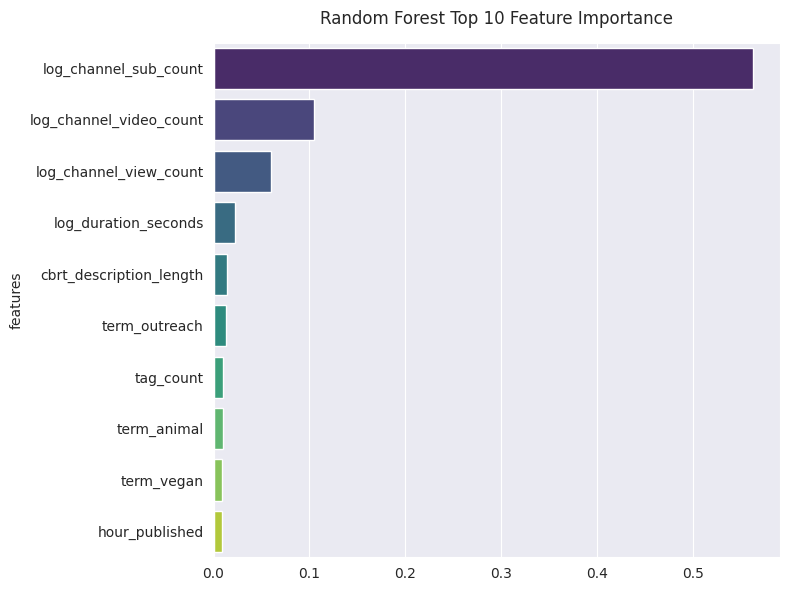

In [80]:
# visualize top 10 important features
sns.set_style("darkgrid")
plt.subplots(figsize=(8, 6))
sns.barplot(x=features_top_10.values, y=features_top_10.index, hue=features_top_10.index, palette="viridis", legend=False, orient="h")
plt.title("Random Forest Top 10 Feature Importance", y=1.02)
plt.ylabel("features")
plt.tight_layout()

# save png
plt.savefig("images/random_forest_top_10_feature_importance.png", dpi=300)

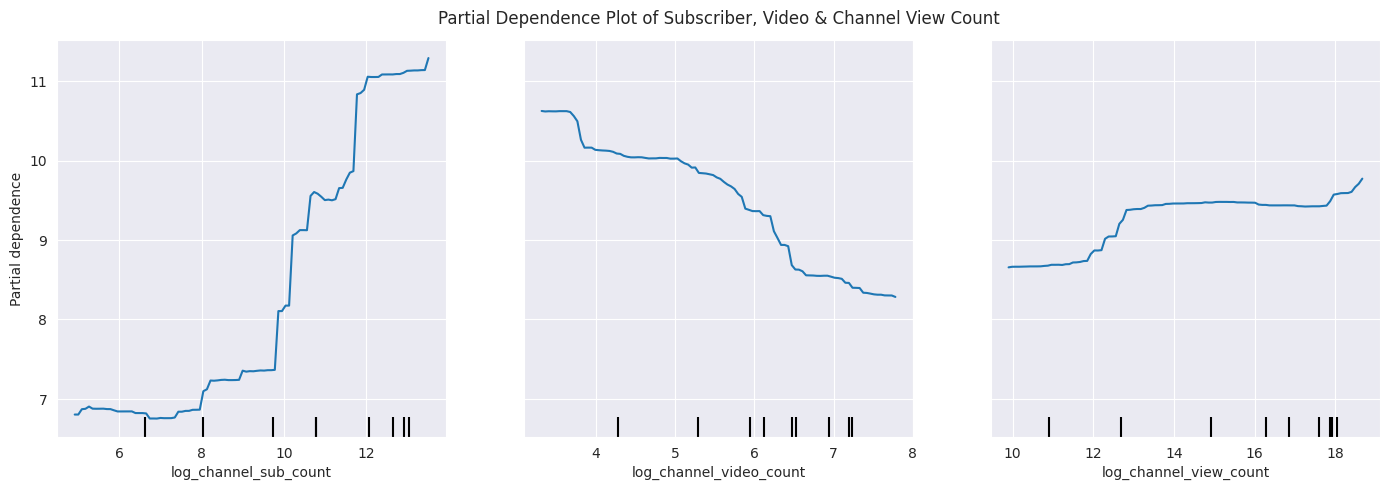

In [84]:
fig, ax = plt.subplots(figsize=(14, 5))
PartialDependenceDisplay.from_estimator(estimator=pipeline, X=X_train, features=["log_channel_sub_count", "log_channel_video_count", "log_channel_view_count"], ax=ax, grid_resolution=100)
ax.set_title("Partial Dependence Plot of Subscriber, Video & Channel View Count", y=1.02)
plt.tight_layout()


/home/lance_lucifer/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 30 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


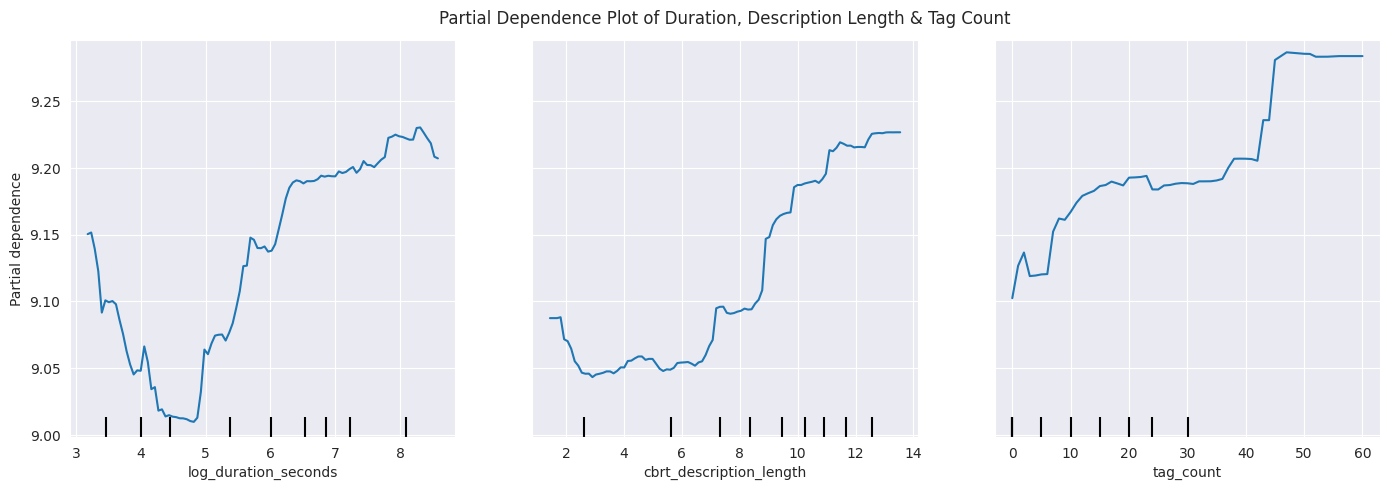

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))
PartialDependenceDisplay.from_estimator(estimator=pipeline, X=X_train, features=["log_duration_seconds", "cbrt_description_length", "tag_count"], ax=ax, grid_resolution=100)
ax.set_title("Partial Dependence Plot of Duration, Description Length & Tag Count", y=1.02)
plt.tight_layout()

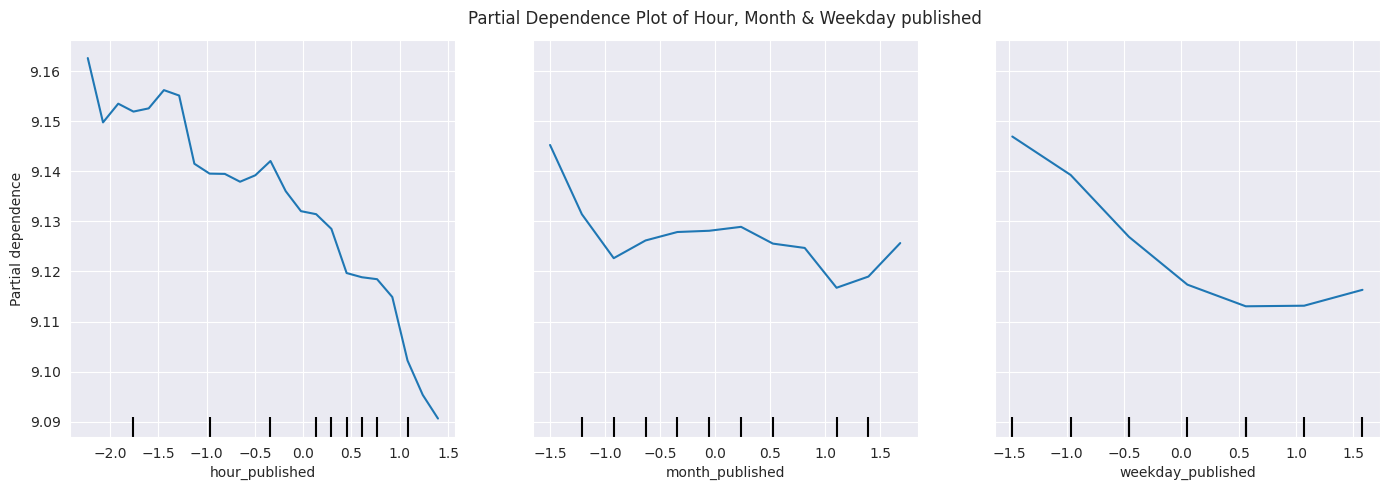

In [60]:
fig, ax = plt.subplots(figsize=(14, 5))
PartialDependenceDisplay.from_estimator(estimator=rf, X=X_train_scaled, features=["hour_published", "month_published", "weekday_published"], ax=ax, grid_resolution=100)
ax.set_title("Partial Dependence Plot of Hour, Month & Weekday published", y=1.02)
plt.tight_layout()